# Sleep Efficiency — ML Final Project (Single Notebook)

Notebook único com tudo: carregamento de dados, engenharia de features, treino com GroupKFold, verificação contra vazamento (shuffle), treino final, métricas (AUC/Precision/Recall/F1), seleção de limiar e gráficos (ROC, PR e matriz de confusão).

In [11]:
# Configurações gerais
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Reduz threads BLAS para estabilidade
import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

# Caminhos
DATA_PATH = Path('./data/sleep.csv')  # ajuste se necessário
REPORTS_DIR = Path('reports')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print('Usando DATA_PATH =', DATA_PATH.resolve())

Usando DATA_PATH = /home/vini/dev/machine-learning-final-project/src/data/sleep.csv


In [12]:
# Utilitários de dados
def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    return df

def make_target(df: pd.DataFrame) -> pd.Series:
    # alvo: ineficiência do sono (< 0.85)
    return (df["Sleep efficiency"] < 0.85).astype(int)

def _circ(ts):
    if pd.isna(ts):
        return np.nan, np.nan
    rad = (ts.hour + ts.minute/60.0)/24.0 * 2*np.pi
    return np.cos(rad), np.sin(rad)

def engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    bt = pd.to_datetime(df.get("Bedtime"), errors="coerce")
    wu = pd.to_datetime(df.get("Wakeup time"), errors="coerce")
    df["bt_cos"], df["bt_sin"] = zip(*bt.apply(_circ))
    df["wu_cos"], df["wu_sin"] = zip(*wu.apply(_circ))
    dur = (wu - bt).apply(lambda d: d.total_seconds()/3600.0 if pd.notna(d) else np.nan)
    dur = dur.mask(dur < 0, dur + 24.0)
    df["time_in_bed"] = dur

    df["awak_per_h"] = df["Awakenings"] / df["Sleep duration"].replace(0, np.nan)
    df["low_duration"] = (df["Sleep duration"] < 7.0).astype(int)

    df = pd.get_dummies(df, columns=[c for c in ["Gender", "Smoking status"] if c in df.columns], drop_first=True)

    keep = [
        "bt_cos","bt_sin","wu_cos","wu_sin","time_in_bed",
        "Sleep duration",
        "REM sleep percentage","Deep sleep percentage","Light sleep percentage",
        "Awakenings","awak_per_h","low_duration",
        "Caffeine intake","Alcohol consumption","Exercise frequency",
        "Age"
    ] + [c for c in df.columns if c.startswith("Gender_") or c.startswith("Smoking status_")]
    df = df.reindex(columns=keep)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

    # sanitização básica
    df = df.loc[:, df.notna().any()]
    const = df.nunique(dropna=False) <= 1
    df = df.loc[:, ~const]
    return df

def sanitize_features_targets(Xf: pd.DataFrame, y: pd.Series):
    Xf = Xf.copy()
    Xf.columns = Xf.columns.map(lambda c: str(c).strip().replace(" ", "_"))
    for col in Xf.columns:
        if not np.issubdtype(Xf[col].dtype, np.number):
            Xf[col] = pd.to_numeric(Xf[col], errors="coerce")
    Xf = Xf.loc[:, Xf.notna().any(axis=0)]
    const_mask = Xf.nunique(dropna=False) <= 1
    if const_mask.any():
        Xf = Xf.loc[:, ~const_mask]
    arr = Xf.to_numpy(dtype=float, copy=False)
    finite_mask = np.isfinite(arr).all(axis=1)
    Xf = Xf.loc[finite_mask]
    y = y.loc[Xf.index]
    Xf = Xf.dropna(axis=0)
    y = y.loc[Xf.index]
    return Xf, y


In [13]:
# Modelos candidatos
def logistic_pipe():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
    ])

def gbm_pipe():
    clf = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=10,
        n_jobs=1,
        random_state=42,
    )
    return CalibratedClassifierCV(clf, method="sigmoid", cv=3, n_jobs=1)

def metrics(y_true, prob, thr=0.5):
    y_pred = (prob >= thr).astype(int)
    return {
        "auc": roc_auc_score(y_true, prob),
        "f1": f1_score(y_true, y_pred)
    }


In [14]:
# Treino com GroupKFold + verificação com y embaralhado
df = load_data(DATA_PATH)
Xf = engineer(df)
y = make_target(df)
Xf, y = sanitize_features_targets(Xf, y)

groups = df.get("Subject ID", pd.Series(np.arange(len(df), dtype=int), index=df.index))
groups = pd.Series(groups).loc[Xf.index]

gkf = GroupKFold(n_splits=max(2, min(5, int(pd.Series(groups).nunique()))))
candidates = [("log_reg", logistic_pipe), ("gbm", gbm_pipe)]

results = []
best_name, best_auc = None, -np.inf
best_builder = None
for name, builder in candidates:
    fold_scores = []
    for trn_idx, val_idx in gkf.split(Xf, y, groups):
        model = builder()
        X_tr, y_tr = Xf.iloc[trn_idx], y.iloc[trn_idx]
        X_va, y_va = Xf.iloc[val_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_va)[:, 1]
        fold_scores.append(metrics(y_va, prob))
    results.append((name, fold_scores))
    auc_mean = float(np.mean([s["auc"] for s in fold_scores]))
    if auc_mean > best_auc:
        best_auc = auc_mean
        best_name = name
        best_builder = builder

# baseline com y embaralhado (sanidade)
rng = np.random.default_rng(123)
y_shuf = pd.Series(rng.permutation(y.values), index=y.index)
results_shuf = []
for name, builder in candidates:
    fold_scores = []
    for trn_idx, val_idx in gkf.split(Xf, y_shuf, groups):
        model = builder()
        X_tr, y_tr = Xf.iloc[trn_idx], y_shuf.iloc[trn_idx]
        X_va, y_va = Xf.iloc[val_idx], y_shuf.iloc[val_idx]
        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_va)[:, 1]
        fold_scores.append(metrics(y_va, prob))
    results_shuf.append((name, fold_scores))

summary = {
    "best_model": best_name,
    "best_auc_cv": best_auc,
    "cv_details": results,
    "cv_details_shuffled_y": results_shuf,
    "n_rows_train": int(Xf.shape[0]),
    "n_cols_train": int(Xf.shape[1]),
    "n_groups": int(pd.Series(groups).nunique()),
}
print(json.dumps(summary, indent=2))

with open(REPORTS_DIR/"train_debug.json", "w") as f:
    json.dump(summary, f, indent=2)

[LightGBM] [Info] Number of positive: 123, number of negative: 96
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561644 -> initscore=0.247836
[LightGBM] [Info] Start training from score 0.247836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

Limiar escolhido (F1-max): 0.30601905737672264


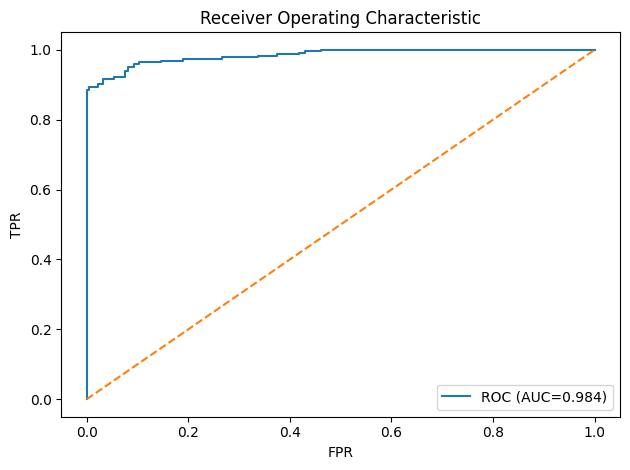

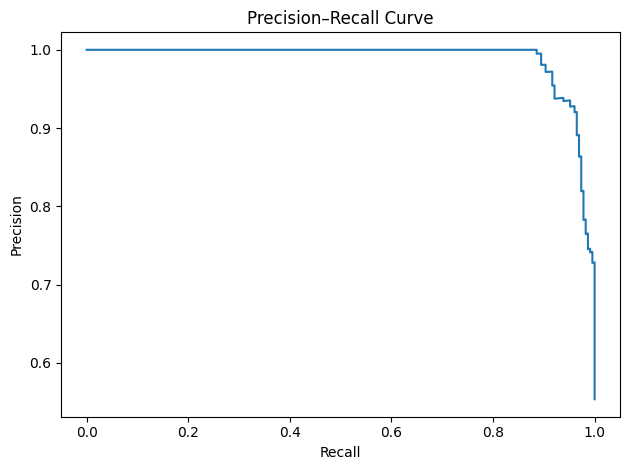

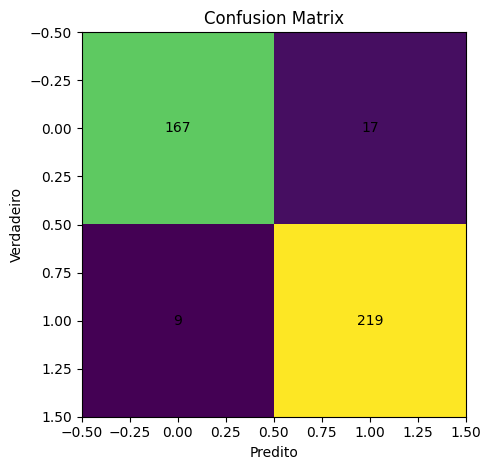

{
  "threshold": 0.30601905737672264,
  "auc": 0.9839101830663615,
  "precision": 0.9279661016949152,
  "recall": 0.9605263157894737,
  "f1": 0.9439655172413793,
  "support_pos": 228,
  "n_samples": 412,
  "plots": {
    "roc": "reports/holdin_roc.png",
    "pr": "reports/holdin_pr.png",
    "cm": "reports/holdin_cm.png"
  }
}


In [15]:
# Treino final no conjunto completo com o melhor modelo
assert best_builder is not None
final_model = best_builder()
final_model.fit(Xf, y)

# Probabilidades no hold-in (para curvas/inspeção)
prob_all = final_model.predict_proba(Xf)[:,1]

# Seleção de limiar por F1 (pode escolher 'precision' ou 'recall')
prec, rec, thr = precision_recall_curve(y, prob_all)
f1s = 2*(prec*rec)/(prec+rec + 1e-12)
best_idx = int(np.nanargmax(f1s))
best_thr = 0.5 if best_idx == len(thr) else float(thr[best_idx])
print('Limiar escolhido (F1-max):', best_thr)

# Métricas e gráficos
def plot_and_save_curves(y_true, prob, thr, prefix: str):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_true, prob):.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.tight_layout()
    p1 = REPORTS_DIR/f"{prefix}_roc.png"
    plt.savefig(p1)
    plt.show()

    # PR
    prc, rec_, _ = precision_recall_curve(y_true, prob)
    plt.figure()
    plt.plot(rec_, prc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.tight_layout()
    p2 = REPORTS_DIR/f"{prefix}_pr.png"
    plt.savefig(p2)
    plt.show()

    # Matriz de confusão
    y_pred = (prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    p3 = REPORTS_DIR/f"{prefix}_cm.png"
    plt.savefig(p3)
    plt.show()
    return str(p1), str(p2), str(p3)

p_roc, p_pr, p_cm = plot_and_save_curves(y, prob_all, best_thr, prefix="holdin")

y_pred_all = (prob_all >= best_thr).astype(int)
rep = classification_report(y, y_pred_all, output_dict=True)
final_report = {
    "threshold": best_thr,
    "auc": float(roc_auc_score(y, prob_all)),
    "precision": float(rep['1']['precision']),
    "recall": float(rep['1']['recall']),
    "f1": float(rep['1']['f1-score']),
    "support_pos": int(rep['1']['support']),
    "n_samples": int(len(y)),
    "plots": {"roc": p_roc, "pr": p_pr, "cm": p_cm}
}
print(json.dumps(final_report, indent=2))
with open(REPORTS_DIR/"final_report.json", "w") as f:
    json.dump(final_report, f, indent=2)

## Como usar
1. Coloque o CSV em `data/sleep_efficiency.csv` (ou ajuste `DATA_PATH` no primeiro bloco).
2. Execute **de cima para baixo**.
3. Gráficos e relatórios ficarão em `reports/`.